# Project Category Identification NLP Project <a id='Data Overview'></a>

## Table of Contents <a id='2.1_Contents'></a>
* [0. Background](#0)
* [1. Data Import - Building Dataset](#1)
* [2. Target Location Selection](#2)
* [3. Data Understanding](#3)
    * [3.1 Missing Values](#3.1)
    * [3.2 Meter Type Observation](#3.2)
    * [3.3 Building Area Observation](#3.3)
    * [3.4 Building Category Observation](#3.4)
    * [3.5 Building Energy Use Intensity](#3.5)
    * [3.6 Other Building Parameters](#3.6)
* [4.0 Save Data](#4.0)

## 0. Background

I built a web scrapping tool that scraps biding and tendering information from public sectors in Ontario. The public sectors includes regions such as York Region, Peel Region, Halton Region, and cities such as City of Mississauga.

The intend of the project is to use DATA to tell a story about the Competitiveness of the public sector. The collected information are used to conduct the following analysis:

* **Public Sector Market Understanding**: an overview of the public sector markets (services, construction, and goods), how the market changes over time.

* **Competitive Information**: an overview of the performance of private companies in different public sectors. What is their wining rate comparing with their competitors. The private companies includes construction companies such as Maple Reinders Constructors Ltd. and Kenaidan Contracting Ltd., consulting companies such WSP Canada Inc., Hatch Ltd., and good supplying companies.

* **Competitiveness by Category** Different private companies in the public sectors have overlapping skill sets in the public sectors, they may also specialize a niche that company leaders and strategist may not be aware off. The tool intends to use DATA to show competitiveness of each companies in different sectors such as consulting in water & wastewater, construction in civil engineering works, etc.

The collected information includes project names and a generic category information. In order to understand "Competitiveness by Category", the original "generic category" needs to further broken down into detailed categories. There are almost 10k project collected, it is not practical to provide a detailed category to each of the project,. Further more, as more projects be collected, manual tagging the category is timing consuming.

Therefore, Natural Language Processing (NLP) is used to do the category task for current projects and any future projects.

## 0.1 Import Libraries

In [190]:
import pandas as pd
import numpy as np
import dataresource as dr

## 0.2 Import Original Dataset

In [191]:
path = "../NaturalLanguageProcessing/Data.csv"
df = pd.read_csv(path)
df.drop_duplicates(inplace=True)

## 1. Data Wrangling

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9126 entries, 0 to 48198
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_name         9126 non-null   object 
 1   project_name        9126 non-null   object 
 2   bid_classification  7275 non-null   object 
 3   bid_type            9101 non-null   object 
 4   bid_ID              9126 non-null   object 
 5   awarded_date        9124 non-null   object 
 6   awarded_year        9124 non-null   float64
dtypes: float64(1), object(6)
memory usage: 570.4+ KB


In [193]:
df.head()

,client_name,project_name,bid_classification,bid_type,bid_ID,awarded_date,awarded_year
0,York Region,General Contractors And Subcontractors For Sen...,Services,Pre-Qualification,PQ-20-156,05-Mar,2021.0
9,York Region,Supply And Delivery Of As-Required Spill Respo...,Services,Tender,T-20-204,16-Feb,2021.0
13,York Region,Prequalification Of Consultants For The Feasib...,Services,Pre-Qualification,PQ-20-247,25-Jan,2021.0
20,York Region,Detailed Design And Engineering Services For 1...,Services,RFP,P-20-46,11-Feb,2021.0
25,York Region,Waste Electrical And Electronic Equipment (Wee...,Services,Tender,T-20-260,18-Dec,2020.0


## 1.1 Data Exploration

### 1.1.1 Data Exploration - client_name

In [194]:
client_list = df.client_name.unique().tolist()
len(client_list)

19

In [195]:
client_list

['York Region',
 'Waterloo Region',
 'Simcoe County',
 'Peterborough County',
 'Niagara Region',
 'Halton Region',
 'Haldimand County',
 'Durham Region',
 'Dufferin County',
 'City Of Peterborough',
 'City of Orillia',
 'City of London',
 'City of Kawartha Lakes',
 'City of Hamilton',
 'City of Guelph',
 'City of Brantford',
 'City of Barrie',
 'Brant County',
 'Peel Region']

In [196]:
df.groupby(['client_name', 'awarded_year'])['client_name'].count()

client_name   awarded_year
Brant County  2015.0            4
              2016.0           27
              2017.0           58
              2018.0           33
              2019.0           31
                             ... 
York Region   2017.0          253
              2018.0          261
              2019.0          243
              2020.0          203
              2021.0           14
Name: client_name, Length: 101, dtype: int64

There are 19 clients included in the dataset. The client name will not be used as an input for NLP because the client name does not have any affect on the project name and project category.

### 1.1.2 Data Exploration - bid_type

There are a couple of bid types in the business of the public sector: Request for Tender(RFT), Request for Proposal(RFP), Request for Quotation(RFQ), Request for Information (RFI), and Request for Pre-Qualification(RFPQ).

In [197]:
df.bid_type.describe()

count       9101
unique        58
top       Tender
freq        1939
Name: bid_type, dtype: object

In [198]:
df.bid_type.unique().tolist()

['Pre-Qualification',
 'Tender',
 'RFP',
 'Notice of Contract Award',
 'RFI',
 'EOI',
 'RFQ',
 'Request for Tender',
 'Request for Proposal',
 'Consultant Selection',
 'Consultant Selection Stage 1',
 'Expression of Interest',
 'Request for Quote',
 'Consultant Selection Stage 2',
 'Cooperative Tender',
 'Request for Tender (Carpentry)',
 'Request For Proposal',
 'Request For PreQualification',
 'Request for Quotation',
 'RFT',
 'Request for Offer',
 'Request For Tender',
 'Request For Quotation',
 'Request for Proposal(N)',
 'RFPQ',
 nan,
 'N',
 'NRFP',
 'Request For Quotations',
 'Request for Supplier Pre-qualification',
 'ITT',
 'RFSQ',
 'RFEOI',
 'Request for Qualifications',
 'Request for Quotation (Formal)',
 'Informal Request for Quotation',
 'Request for Information',
 'Request For Supplier Qualification',
 'RFT - Public Works',
 'RFT - Construction - Stipulated Price - CCDC',
 'RFT - Construction - Unit Price',
 'RFT - Goods and Services',
 'RFP - Goods and Services',
 'RFT - 

In [199]:
df.bid_type.value_counts(dropna = False)

Tender                                          1939
RFP                                             1529
RFT                                             1258
Request for Tender                               929
RFQ                                              425
Pre-Qualification                                317
Request For Proposal                             297
Request for Proposal                             237
Request For Quotation                            195
Request For Tender                               176
RFT - Goods and Services                         157
RFPQ                                             154
RFT - Public Works                               152
Consultant Selection                             134
RFP - Goods and Services                         104
RFQ – Low Bid                                    101
ITT                                               97
RFT - Construction - Stipulated Price - CCDC      91
Request for Quotation (Formal)                

As we can see the bid types are not unified across different regions/cities, a hashmap is developed to revise values.

In [200]:
df.bid_type = df.bid_type.apply(lambda x : dr.bid_type_Standard.get(x))

In [201]:
df.bid_type.value_counts()

Request for Tender(RFT)                5014
Request for Proposal(RFP)              2194
Request for Quotation(RFQ)             1037
Request for Pre-Qualification(RFPQ)     747
Request for Information (RFI)            61
Others                                   48
Name: bid_type, dtype: int64

In [202]:
df.dropna(subset=["bid_type"], inplace=True)

### 1.1.3 Data Explanation - bid_classification

In [203]:
df.bid_classification.unique()

array(['Services', 'Construction', 'Goods', nan], dtype=object)

In [204]:
df.bid_classification.value_counts(dropna = False)

Services        3384
Construction    2673
NaN             1851
Goods           1193
Name: bid_classification, dtype: int64

In [205]:
df = df.dropna(subset=['awarded_year'])
df.awarded_year.astype('int')

0        2021
9        2021
13       2021
20       2021
25       2020
         ... 
48183    2018
48189    2017
48192    2018
48193    2018
48198    2018
Name: awarded_year, Length: 9099, dtype: int64

<AxesSubplot:>

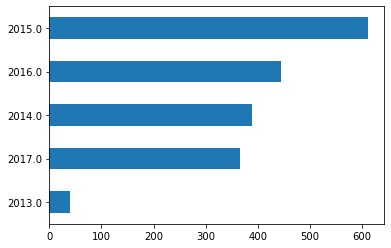

In [206]:
df[df.bid_classification.isnull()].awarded_year.value_counts().sort_values().plot(kind = 'barh')

In [207]:
df[df.bid_classification.isnull()].awarded_year.value_counts().sum()

1851

In [208]:
df.awarded_year.value_counts().sum()

9099

Note that majority of the projects that miss bid classification are the projects from 5 years ago and more. The projects that missing the bid classification accounts for approximately 21% of the data. Our goal of the project is to identify project category for the projects using project name and possibly the bid classification and bid type. We will drop the 21% of the data that does not the bid classification information.

In [209]:
df.dropna(subset=["bid_classification"], inplace=True)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 48198
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_name         7248 non-null   object 
 1   project_name        7248 non-null   object 
 2   bid_classification  7248 non-null   object 
 3   bid_type            7248 non-null   object 
 4   bid_ID              7248 non-null   object 
 5   awarded_date        7248 non-null   object 
 6   awarded_year        7248 non-null   float64
dtypes: float64(1), object(6)
memory usage: 453.0+ KB


### 1.1.4 Data Explanation - bid_ID

In [211]:
df.bid_ID.value_counts().sort_values(ascending=False)

C12-06-18    39
17-151        3
17-126        3
17-123        2
17-142        2
             ..
2017-423O     1
2017-631P     1
2017-665T     1
2017-764T     1
2017-464T     1
Name: bid_ID, Length: 7140, dtype: int64

In [212]:
df.bid_ID.unique().size

7140

Note that there are bid that have duplicates IDs.

### 1.1.5 Remove Columns

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 48198
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_name         7248 non-null   object 
 1   project_name        7248 non-null   object 
 2   bid_classification  7248 non-null   object 
 3   bid_type            7248 non-null   object 
 4   bid_ID              7248 non-null   object 
 5   awarded_date        7248 non-null   object 
 6   awarded_year        7248 non-null   float64
dtypes: float64(1), object(6)
memory usage: 453.0+ KB


In [215]:
# columns to be removed, as they are not contribute to the category results
columns = ['client_name', 'bid_ID', 'awarded_date', 'awarded_year']
df = df.drop(columns=columns)
df

,project_name,bid_classification,bid_type
0,General Contractors And Subcontractors For Sen...,Services,Request for Pre-Qualification(RFPQ)
9,Supply And Delivery Of As-Required Spill Respo...,Services,Request for Tender(RFT)
13,Prequalification Of Consultants For The Feasib...,Services,Request for Pre-Qualification(RFPQ)
20,Detailed Design And Engineering Services For 1...,Services,Request for Proposal(RFP)
25,Waste Electrical And Electronic Equipment (Wee...,Services,Request for Tender(RFT)
...,...,...,...
48183,Lawn And Boulevard Maintenance At Various Loca...,Services,Request for Tender(RFT)
48189,Supply Of Network Cabling Services For Peel Re...,Services,Request for Tender(RFT)
48192,Supply And Delivery Of Commercial Off-The-Shel...,Goods,Request for Tender(RFT)
48193,Supply And Delivery Of One Agricultural Tracto...,Goods,Request for Tender(RFT)


In [216]:
df.to_csv("data_cleaned.csv")

## 3.0 Data Observation

### 3.1 Obtain data
Use pandas to read the data I scrapped.

In [84]:
excel_path = '/Users/delinmu/Documents/GitHub/BidTing/result/data.xlsx'
bidding_info = pd.read_excel(excel_path, sheet_name='Ori')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/delinmu/Documents/GitHub/BidTing/result/data.xlsx'

In [ ]:
# a quick view of bidding_info dataframe
bidding_info.head()

### 3.2 Dataframe Observation
A couple of questions I want to know here. 
1. How many unique clients in the dataframe?
2. How many unique projects in the dataframe?
3. A table includes 3 columns: client_name, bid_id, project_name, and awarded_year for me to tell how many projects were on the project over the time span

### 3.2.1 Unique Clients
A simple value_counts() method is used to reveal the information. Alternatively, nunique() can also reveal the information.

In [ ]:
# view of the data type of my dataframe
bidding_info.client_name.value_counts()

Note that value count for each client does not represent number of unique projects.

In [ ]:
len(bidding_info.client_name.value_counts())

In total, we have 19 clients collected in the dataframe. This is good to know how many geographical segementtation  we 